Name: Abdelazim Lokma 



In this notebook, I will be performing a preliminary analysis on the BU Daily Weights excel sheet. My main goal is to try to extract some usefull information relating to how tonnage, which is the one of the main features of this dataset, relates to temperature. 

Importing weather data from VisualCrossing API enpoint:


Datatypes:

WSF2 - Fastest 2-minute wind speed

TAVG - Average Temperature

TMIN - Minimum temperature

TMAX - Maximum temperature

WDF2 - Direction of fastest 2-minute wind

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

weather_data = pd.read_csv('/Users/abdelazimlokma/Downloads/3247190.csv')

daily_weights = pd.read_csv(
    '/Users/abdelazimlokma/Downloads/BU Daily Weights FY22.xlsx - Sheet2.csv')

weather_data = weather_data[weather_data["NAME"] == "BOSTON LOGAN INTERNATIONAL AIRPORT, MA US"]

weather_data = weather_data.dropna(thresh=len(weather_data) - 1, axis=1)

weather_data['DATE'] = pd.to_datetime(weather_data["DATE"])

weather_data["DATE"] = weather_data["DATE"].dt.strftime('%-m/%-d/%Y')

weather_data = weather_data.rename(columns={"DATE": 'Date'})

daily_weights = daily_weights.rename(columns={"Work Order Date": 'Date'})

merged_df = pd.merge(weather_data, daily_weights, on='Date', how='inner')


merged_df = merged_df.drop(['NAME', 'STATION'], axis=1)

display(merged_df)


,Date,AWND,TAVG,TMAX,TMIN,WDF2,WSF2,Customer Key,Location,Address,Material,Tons
0,7/1/2021,4.0,25.4,29.4,20.0,220.0,7.6,31903.0,BU #72 - Rafik B Hariri,853 BEACON ST,Recycling,0.0300
1,7/2/2021,6.3,18.3,20.6,15.0,50.0,9.8,31950.0,BU #89 - Brownstones,91 BAY STATE RD,Recycling,0.0800
2,7/6/2021,6.6,24.9,33.3,20.6,270.0,12.5,31769.0,BU #112B - 949 Comm Ave,36 Cummington Mall,Recycling,0.5670
3,7/6/2021,6.6,24.9,33.3,20.6,270.0,12.5,31946.0,BU #99 - College of Fine Arts,120 ASHFORD STREET,Trash,0.0470
4,7/6/2021,6.6,24.9,33.3,20.6,270.0,12.5,32111.0,BU MED- 815 Albany,815 Albany Street,Compost,0.0725
...,...,...,...,...,...,...,...,...,...,...,...,...
17798,6/30/2022,4.6,22.9,28.3,19.4,320.0,8.9,32111.0,BU #29 - Harriet Richards House,640 Commonwealth Ave,Recycling,0.0000
17799,6/30/2022,4.6,22.9,28.3,19.4,320.0,8.9,32450.0,BU #37 - African Studies,940 Commonwealth Ave,Recycling,0.0250
17800,6/30/2022,4.6,22.9,28.3,19.4,320.0,8.9,32493.0,BU #43 - West Loading Dock,275 Babcock,Recycling,0.0580
17801,6/30/2022,4.6,22.9,28.3,19.4,320.0,8.9,32494.0,BU #78 - 660 Beacon,100 BAY STATE RD,Recycling,0.0555


Currently concerned mainly with finding a connection between outside temperature and tonnage. First I plotted the temperature with relation to the date in order to see how temperature changes throughout the year.

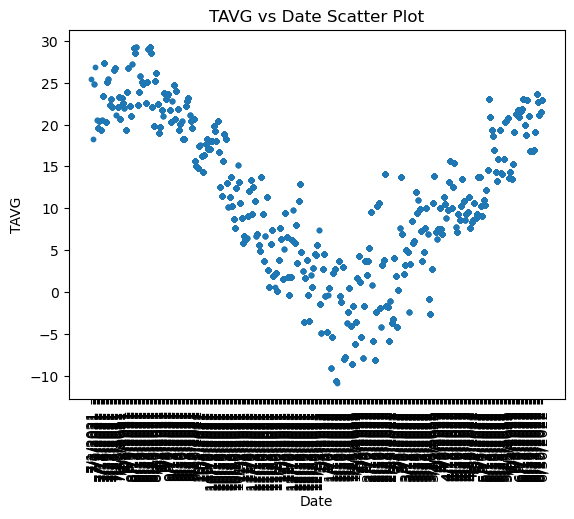

In [5]:
temp_date = merged_df[["Date", "TAVG"]]

temp_date.shape



plt.scatter(temp_date['Date'], temp_date['TAVG'], s=10)

plt.xticks(rotation=90)



# Set the labels for X and Y axis
plt.xlabel('Date')
plt.ylabel('TAVG')
plt.title('TAVG vs Date Scatter Plot')

plt.show()


The code below is my attempt to plot tonnage with relation to the date. My hope was to find a similar behavior with how the tonnage changes based on the date. But the plot below does not clearly show anything. 

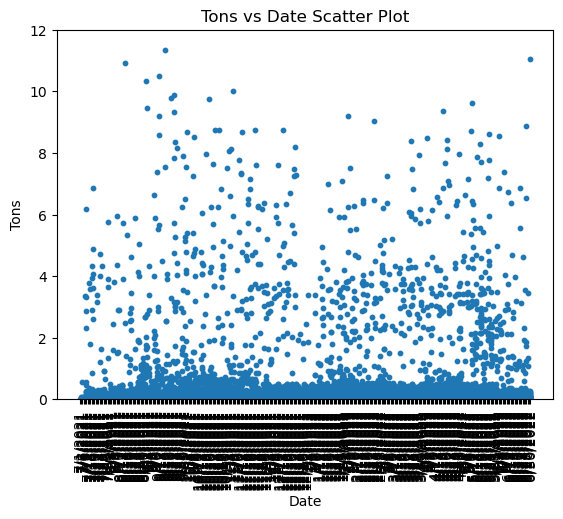

In [6]:
weight_date = merged_df[["Date", "Tons"]]

weight_date.shape


plt.scatter(weight_date['Date'], weight_date['Tons'], s=10)

plt.xticks(rotation=90)


# Set the labels for X and Y axis
plt.xlabel('Date')
plt.ylabel('Tons')
plt.title('Tons vs Date Scatter Plot')
plt.ylim(0, 12)

plt.show()


Decided to plot tonnage with relation to average daily temperature for a cleaner scatter plot. Still no clear correlation

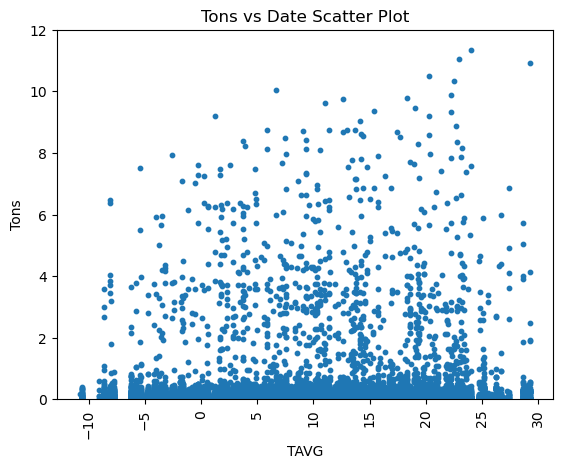

In [7]:
weight_date = merged_df[["TAVG", "Tons"]]

weight_date.shape


plt.scatter(weight_date['TAVG'], weight_date['Tons'], s=10)

plt.xticks(rotation=90)


# Set the labels for X and Y axis
plt.xlabel('TAVG')
plt.ylabel('Tons')
plt.title('Tons vs Date Scatter Plot')
plt.ylim(0, 12)

plt.show()


Now I plan to use K-Means to hopefully find a pattern in the data that may have not been apparent at first. But to do this, I first need to find the optimal number of clusters to use for K-Means. So I will apply k means to a range of K values, then I will measure and plot the silhouette score generated by each k in order to find the highest score. 

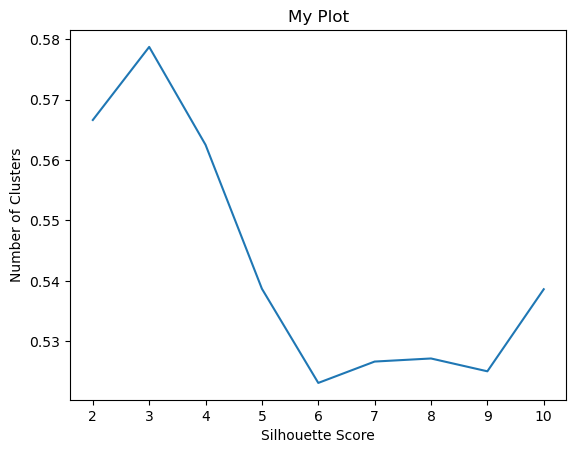

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

features = merged_df[["Tons", "TAVG"]]



scores=[]
k_vals = range(2, 11)

for k in range(2,11):
    kmeans = KMeans(n_clusters=k, init='random')
    kmeans.fit(features)
    silhouette_avg = silhouette_score(features, kmeans.labels_)
    scores.append(silhouette_avg)
    

fig, ax = plt.subplots()

ax.plot(k_vals, scores)


ax.set_title('My Plot')
ax.set_xlabel('Silhouette Score')
ax.set_ylabel('Number of Clusters')


plt.show()



The plot above shows that the clusters are most optimal when k = 3, so i go ahead and plot the result generated by a K-means of 3 clusters. I also mapped each datapointto its cluster and plotted the centroids of each cluster. The graph below shows no real discernable information. However, it seems t our outliers for each clusters increase in their tonnage value relative to an increase in temperature. 

/var/folders/m5/c0jw_w4s2012vgf1mwfyb3b00000gn/T/ipykernel_13813/3482247522.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['label'] = kmeans.labels_


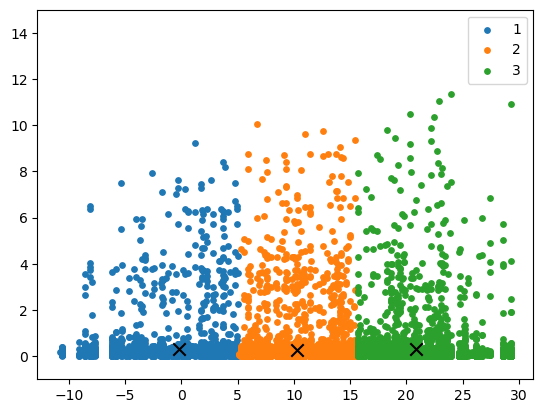

In [9]:
features = merged_df[["Tons", "TAVG"]]
kmeans = KMeans(n_clusters=3, init='random')
label =kmeans.fit_predict(features)

centroids = kmeans.cluster_centers_
labels_set = np.unique(kmeans.labels_)

features['label'] = kmeans.labels_


for i in labels_set:
    plt.scatter(features.loc[label == i, "TAVG"],
                features.loc[label == i, "Tons"], label=i+1, s=15)


plt.scatter(centroids[:, 1], centroids[:, 0], s=80, color='black', marker='x')
plt.ylim([-1, 15])
plt.legend()
plt.show()


Now i think it would be a good idea to cluster the data by trash type, as it seems using Kmeans provides no real discernable information. 

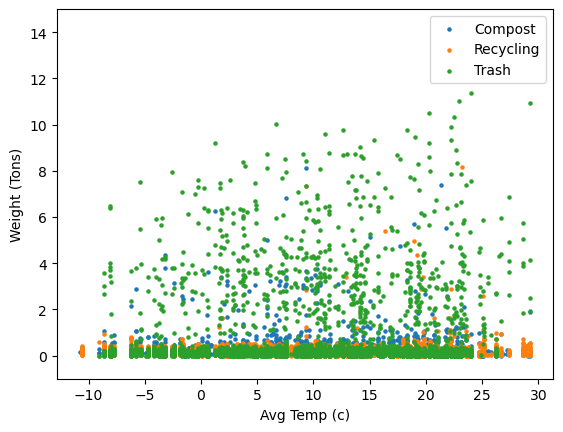

In [26]:
features = merged_df[["Tons", "TAVG"]]

label = merged_df["Material"]
labels_set = np.unique(label)

for i in labels_set:
    plt.scatter(features.loc[label == i, "TAVG"],
                features.loc[label == i, "Tons"], label=i, s=5)


plt.ylim([-1, 15])
plt.xlabel('Avg Temp (c)')  # add x label
plt.ylabel('Weight (Tons)')  # add y label
plt.legend()
plt.show()


From the graph above, we can clearly see what the client confirmed, which is that trash containers are the heaviest, but what we can see here is that trash shipments seem to be increasing in weight as the temperature increases. A possible approach to track this would be to measure the average weight collected at each temperature for each type of waste

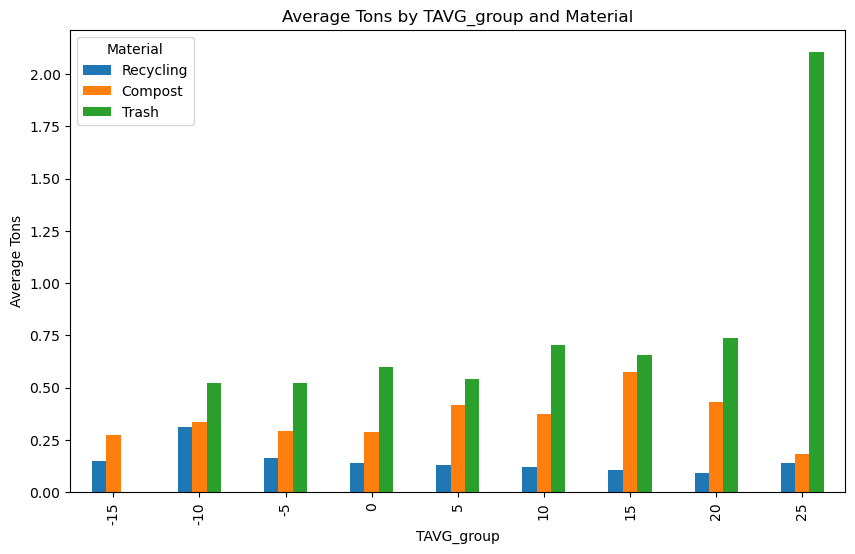

In [73]:


ranges = range(-15, 35, 5)

merged_df['TAVG_group'] = pd.cut(
    merged_df['TAVG'], bins=ranges, labels=ranges[:-1])


grouped_df = merged_df.groupby(['TAVG_group', 'Material'])[
    'Tons'].mean().unstack()

grouped_df = grouped_df.reindex(columns=['Recycling', 'Compost', 'Trash'])

grouped_df.plot(kind='bar', figsize=(10, 6))




plt.title('Average Tons by TAVG_group and Material')
plt.xlabel('TAVG_group')
plt.ylabel('Average Tons')


plt.show()


The grouped bar chart above shows that, on average, the tonnage of Trash containers increases with temperature. For the recycing containers, it seems to decrease in most cases. However for Compost, it is difficult to tell. We may need to find the pearson correlation coeficient for each container type. 

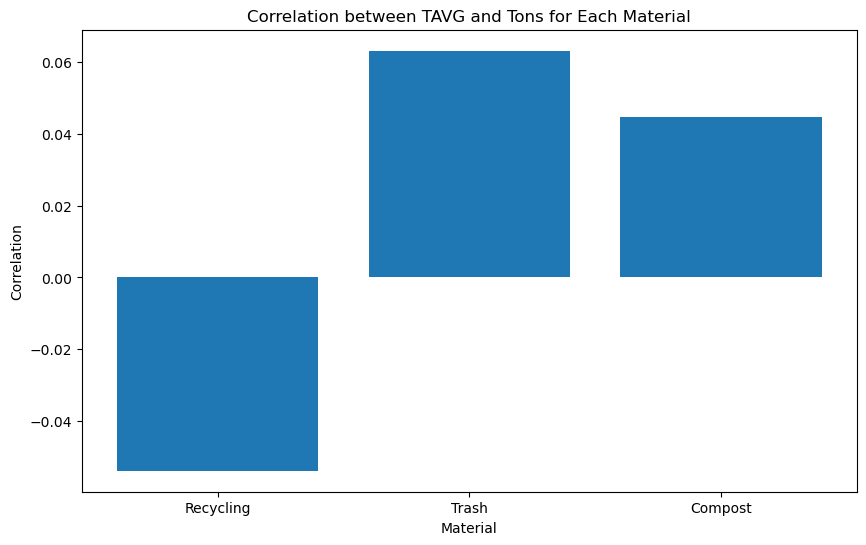

In [47]:
temp_vals_trash = merged_df[merged_df['Material'] == 'Trash']['TAVG']
temp_vals_compost = merged_df[merged_df['Material'] == 'Compost']['TAVG']
temp_vals_recycling = merged_df[merged_df['Material'] == 'Recycling']['TAVG']

tonnage_trash = merged_df[merged_df['Material'] == 'Trash']['Tons']
tonnage_compost = merged_df[merged_df['Material'] == 'Compost']['Tons']
tonnage_recycling = merged_df[merged_df['Material'] == 'Recycling']['Tons']




trash_correllation = np.corrcoef(tonnage_trash, temp_vals_trash)[0, 1]
compost_correllation = np.corrcoef(tonnage_compost, temp_vals_compost)[0, 1]
recycling_correllation = np.corrcoef(tonnage_recycling, temp_vals_recycling)[0, 1]


corr_values = [recycling_correllation,
               trash_correllation, compost_correllation]


fig, ax = plt.subplots(figsize=(10, 6))
x_data = merged_df['Material'].unique()
ax.bar(x_data, corr_values)
ax.set_xlabel('Material')
ax.set_ylabel('Correlation')
ax.set_title('Correlation between TAVG and Tons for Each Material')
plt.show()



Interestingly, the bar chart above reveals more detail about recycling containers, it appears recycling tonnage goes down as temperatures increase. Wheras there seems to be a minor positive correlation between Trash/Compost tonnage with Average daily temperature. 